### Transfer Learning with TensorFlow part 2: Fine Tuning

In [ ]:
# Check if we are using GPU
!nvidia-smi

Tue Feb  8 13:26:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Created bunch of helper funtions 



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-08 13:26:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-08 13:26:25 (47.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get Some Data

Now we are going to use the pretrained models within `tf.keras.appilcations` and apply them to our own problem (recogninzing images of food)

In [ ]:
# Get 10% of training data for 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2022-02-08 13:26:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   167MB/s    in 1.0s    

2022-02-08 13:26:29 (167 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("/content/10_food_classes_10_percent.zip")

In [ ]:
# Check out how many images are and subdirectories are in our datasets
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode="categorical"
                                                                            )

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a bacth of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.80500000e+02 1.54086731e+02 7.11989822e+01]
   [1.90714279e+02 1.67571426e+02 9.05714340e+01]
   [1.76658157e+02 1.57719391e+02 9.03724442e+01]
   ...
   [9.07652283e+00 7.07652283e+00 8.50505066e+00]
   [9.95413876e+00 7.95413876e+00 8.95413876e+00]
   [1.34131727e+01 1.14131727e+01 1.24131727e+01]]

  [[1.61234695e+02 1.34499985e+02 6.02346916e+01]
   [1.60198975e+02 1.37051025e+02 6.86173477e+01]
   [1.46086731e+02 1.26372444e+02 6.56734695e+01]
   ...
   [9.98469543e+00 7.98469543e+00 8.98469543e+00]
   [1.10765448e+01 1.00765448e+01 8.07654476e+00]
   [1.06632252e+01 9.66322517e+00 7.66322517e+00]]

  [[1.34183670e+02 1.08127556e+02 4.49183655e+01]
   [1.33658157e+02 1.11301025e+02 5.44132652e+01]
   [1.26928566e+02 1.06545914e+02 5.75969391e+01]
   ...
   [7.76522827e+00 6.76522827e+00 2.76522827e+00]
   [9.21428585e+00 8.21428585e+00 4.00000000e+00]
   [1.20715332e+01 1.10715332e+01 6.85724735e+00]]

  ...

  [[8.26989822e+01 3.70509872e+01 2.98976779e+00]
   [8

### Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it run's our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns are'nt updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="gloabal_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")
# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the putputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25*len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_leaarning",
                                                                        experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_leaarning/10_percent_feature_extraction/20220208-132644


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - 41s 568ms/step - loss: 1.9545 - accuracy: 0.3493 - val_loss: 1.3831 - val_accuracy: 0.6497
Epoch 2/5
24/24 [==============================] - 9s 325ms/step - loss: 1.1859 - accuracy: 0.7147 - val_loss: 0.9681 - val_accuracy: 0.7533
Epoch 3/5
24/24 [==============================] - 9s 356ms/step - loss: 0.8727 - accuracy: 0.7880 - val_loss: 0.7824 - val_accuracy: 0.7845
Epoch 4/5
24/24 [==============================] - 11s 407ms/step - loss: 0.7166 - accuracy: 0.8213 - val_loss: 0.6810 - val_accuracy: 0.8141
Epoch 5/5
24/24 [==============================] - 10s 385ms/step - loss: 0.6292 - accuracy: 0.8373 - val_loss: 0.6235 - val_accuracy: 0.8158


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 13s 150ms/step - loss: 0.6217 - accuracy: 0.8360


[0.6216958165168762, 0.8360000252723694]

In [ ]:
# Check the layers in our model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloabal_average_pooling_lay  (None, 1280)             0         
 er (GlobalAveragePooling2D)                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


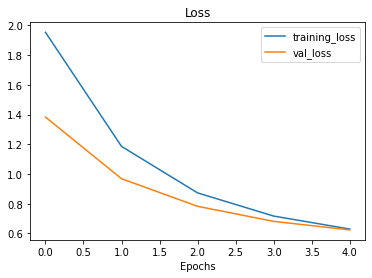

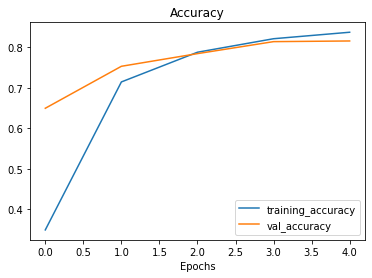

In [ ]:
# Check our model's training curve
plot_loss_curves(history_10_percent)

### Getting feature vector from a trained model

Let's demonstrte the Gloabal Average Pooling 2D layer....

we have a tensor after our model goes through `base_model` of shape (None, 7,7,1280).

But then, when it passes through GloabalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GloabalAveragePooling2D

In [ ]:
import tensorflow as tf


In [ ]:
# Define the input shape
input_shape =(1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# pass the random tensor to Global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global average Pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor:{global_average_pooled_tensor.shape}")


Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global average Pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor:(1, 3)


In [ ]:
# Lets replicate the GloabalAveragePooled2D
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

try GloabalMaxPool2D

**NOTE** 

One of the reasons feature extraxtion transfer learning is named how it is , is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GloabalAveragePooling2D()` layer) which can then be used to extract patterns out of our own specific problem.

### Running a series of transfer learning experiments

We'have seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set-up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmenttion
3.`model_3` - use fine-tunning transfer learning with 10% of the training data with data augmentation
4.`model_4` use fine-tuning with 100% of the training data with data augmentation.

**Note** throughout all the experiment the same test data will be used to evaluate the model... thid ensures consistency across the models.


### Getting and preparing data for preprocessing for model_1

In [ ]:
 ### Download and unzip data
 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-02-08 13:28:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 64.233.182.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   113MB/s    in 1.1s    

2022-02-08 13:28:32 (113 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
unzip_data("/content/10_food_classes_1_percent.zip")

In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [ ]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default-32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)                                                                          

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
 * `tf.keras.layers.experimental.preprocessing()`

Benifits of this:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create data_augmentation stage with horizontal flipping, rotation, zooms, etc.
data_augmentation = keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   #preprocessing.rescale(1./255) # Keep for models like ResNet50V2, but EfficientNet already has it                                   
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)


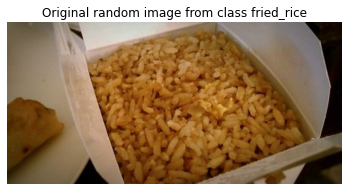

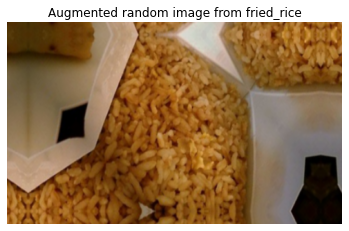

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from {target_class}")
plt.axis(False);
#print(random_image_path)

## Model_1: Feature extraction transfer learning with only 1% training data with augmentation


In [ ]:
# Setup input shape and base model, freezing the base model layer
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# give base model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output feature of the base model
x = layers.GlobalAveragePooling2D(name="gloabal_average_pooling")(x)

# put a dense layer on as the input
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1=model_1.fit(train_data_1_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_1_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25*len(test_data)),
                      # Track model training logs
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                             experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220208-132841


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
3/3 [==============================] - 21s 3s/step - loss: 2.3768 - accuracy: 0.1143 - val_loss: 2.2242 - val_accuracy: 0.1875
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.2033 - accuracy: 0.2143 - val_loss: 2.1243 - val_accuracy: 0.2549
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9625 - accuracy: 0.4143 - val_loss: 2.0225 - val_accuracy: 0.3059
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7767 - accuracy: 0.5429 - val_loss: 1.9324 - val_accuracy: 0.3520
Epoch 5/5
3/3 [==============================] - 8s 3s/step - loss: 1.6542 - accuracy: 0.6143 - val_loss: 1.8316 - val_accuracy: 0.4178


In [ ]:
# Check out model_summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloabal_average_pooling (Gl  (None, 1280)             0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 13s 157ms/step - loss: 1.8353 - accuracy: 0.4276


[1.8352588415145874, 0.4275999963283539]

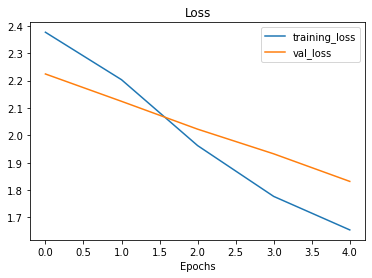

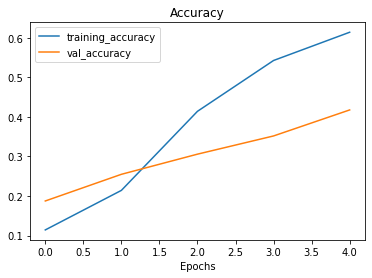

In [ ]:
# How do the model with one percent of data augmentation loss curves look?
plot_loss_curves(history_1)

## Model_2: Feature extraction transfer learing with 10% data augmaentation

In [ ]:
# Get data
#!wget
#unzip

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
    #preprocessing.Rescalling(1./255) # if using models such as ResNet50V2                            
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmented imagers to base model but keep it in inference mode,this also ensures batchnorms layers don't get updated
x = layers.GlobalAveragePooling2D(name="gloabal_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model_2
model_2.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloabal_average_pooling_2D   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckPoint Callback

The ModelCheckpoint callback intermediately save our model (the full model or just the weights) during training.This is usefull so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", #save every epoch
                                                         verbose=1)

### Fit Model_2 passing in ModelCheckPoint Callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_lerning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_lerning/10_percent_data_aug/20220208-133001


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9886 - accuracy: 0.3627
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 849ms/step - loss: 1.9886 - accuracy: 0.3627 - val_loss: 1.4984 - val_accuracy: 0.6497
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3547 - accuracy: 0.6933
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 615ms/step - loss: 1.3547 - accuracy: 0.6933 - val_loss: 1.0912 - val_accuracy: 0.7270
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0524 - accuracy: 0.7467
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 613ms/step - loss: 1.0524 - accuracy: 0.7467 - val_loss: 0.8918 - val_accuracy: 0.7780
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8684 - 

In [ ]:
# Results of model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.6217 - accuracy: 0.8360


[0.6216954588890076, 0.8360000252723694]

In [ ]:
# Checking model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 131ms/step - loss: 0.6912 - accuracy: 0.8052


[0.6912205815315247, 0.8051999807357788]

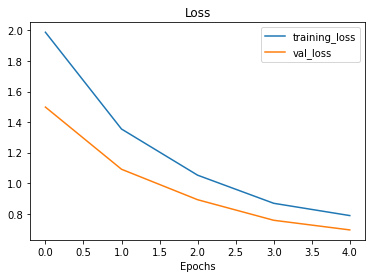

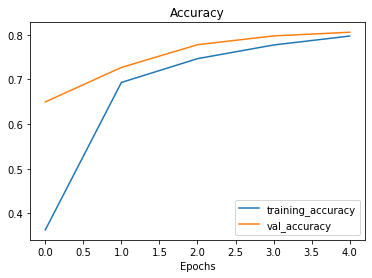

In [ ]:
# Plotting loss curves for model_2
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weinghts
Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weinghts and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate mdoel_2 with loaded weights
loaded_weights_model_results =model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.6912 - accuracy: 0.8052


In [ ]:
 # If the results from our previously evaluated model_2 match the loaded weights, everything works!
results_10_percent_data_aug == loaded_weights_model_results

True

In [ ]:
results_10_percent_data_aug

[0.6912205815315247, 0.8051999807357788]

In [ ]:
loaded_weights_model_results

[0.6912205815315247, 0.8051999807357788]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the actual difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))


[0. 0.]


## Model_3: Fine-tunning an existing model on 10% of the data

**NOTE** 

Fine-tuning usually works best _after_ training a feature extraction model for few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are the layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7ae2057f10> True
<keras.engine.sequential.Sequential object at 0x7f7ae2057c10> True
<keras.engine.functional.Functional object at 0x7f7ae321b550> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f7ae27d9b90> True
<keras.layers.core.dense.Dense object at 0x7f7ae3728890> True


In [ ]:
# What layers in ou base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layerd of our base_model.trainable = true
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Keep learning rate 10X lower 
                metrics=["accuracy"])

In [ ]:
# Check which layers are now trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

🔑 Note: When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [ ]:
# Now we have unfrozen some of the layers closer to the top, how many variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # Start training from last previous last epochs
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220208-133249


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
24/24 [==============================] - 32s 734ms/step - loss: 0.6972 - accuracy: 0.7947 - val_loss: 0.5886 - val_accuracy: 0.8076
Epoch 6/10
24/24 [==============================] - 15s 618ms/step - loss: 0.5556 - accuracy: 0.8440 - val_loss: 0.5256 - val_accuracy: 0.8141
Epoch 7/10
24/24 [==============================] - 12s 503ms/step - loss: 0.5155 - accuracy: 0.8467 - val_loss: 0.5265 - val_accuracy: 0.8191
Epoch 8/10
24/24 [==============================] - 16s 656ms/step - loss: 0.4720 - accuracy: 0.8627 - val_loss: 0.5318 - val_accuracy: 0.8158
Epoch 9/10
24/24 [==============================] - 15s 597ms/step - loss: 0.4122 - accuracy: 0.8707 - val_loss: 0.5190 - val_accuracy: 0.8141
Epoch 10/10
24/24 [==============================] - 12s 475ms/step - loss: 0.3728 - accuracy: 0.8893 - val_loss: 0.5216 - val_accuracy: 0.8224


In [ ]:
# Evaluate the fine-tunned model (model_3 which is actually model_2 fine-tunned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.5069 - accuracy: 0.8256


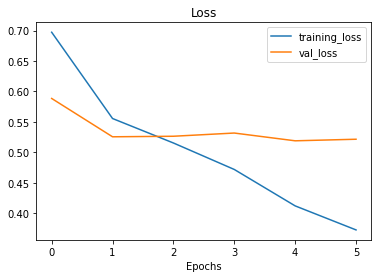

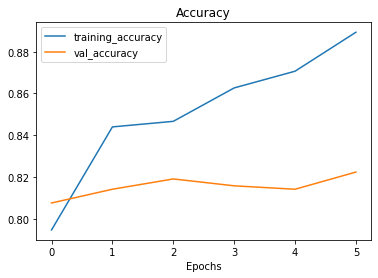

In [ ]:
# Check the loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` funtion works greate with models which have only been fitted once, however, we want something to compare  one series of running fit() with another (eg. before and after tunnnig)

In [ ]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

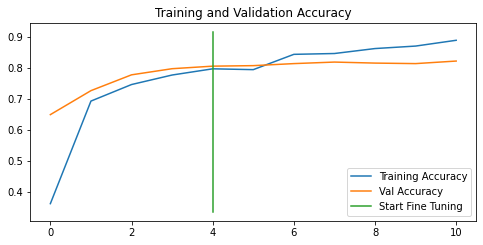

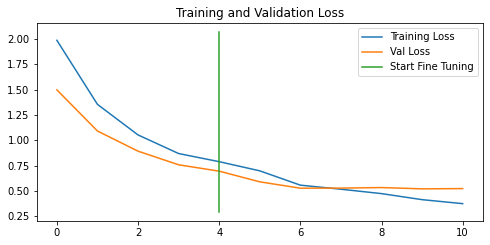

In [ ]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model_4: Fine-tuning and existing model o all the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-02-08 14:13:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   110MB/s    in 4.6s    

2022-02-08 14:13:58 (107 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we have been using for previous experiments (all experiments have used the same dataset)

Let's verify this

In [ ]:
# Evaluate model_2 (this is the fine tuned on 10 percent of the data version)
model_2.evaluate(test_data)

79/79 [==============================] - 12s 141ms/step - loss: 0.5069 - accuracy: 0.8256


[0.5069345831871033, 0.8256000280380249]

In [ ]:
results_fine_tune_10_percent

[0.5069344639778137, 0.8256000280380249]

To train a fine- tuning model(model_4) we need to revert model_2 back to its feature extraction weights

In [ ]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 12s 142ms/step - loss: 0.6912 - accuracy: 0.8052


[0.6912205219268799, 0.8051999807357788]

In [ ]:
# Check to see if out model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6912205815315247, 0.8051999807357788]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using ModelCheckpoint callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [ ]:
# Check which layers are tunnable in whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 gloabal_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base model and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Fit the mode on 100% data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220208-145736


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
235/235 [==============================] - 103s 373ms/step - loss: 0.7292 - accuracy: 0.7655 - val_loss: 0.4272 - val_accuracy: 0.8487
Epoch 6/10
235/235 [==============================] - 75s 319ms/step - loss: 0.5999 - accuracy: 0.8049 - val_loss: 0.3714 - val_accuracy: 0.8799
Epoch 7/10
235/235 [==============================] - 73s 309ms/step - loss: 0.5369 - accuracy: 0.8280 - val_loss: 0.3202 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 68s 285ms/step - loss: 0.4918 - accuracy: 0.8407 - val_loss: 0.3516 - val_accuracy: 0.8865
Epoch 9/10
235/235 [==============================] - 62s 263ms/step - loss: 0.4485 - accuracy: 0.8579 - val_loss: 0.3035 - val_accuracy: 0.8997
Epoch 10/10
235/235 [==============================] - 61s 258ms/step - loss: 0.4209 - accuracy: 0.8641 - val_loss: 0.3422 - val_accuracy: 0.8980


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 132ms/step - loss: 0.3117 - accuracy: 0.9012


[0.3117382228374481, 0.901199996471405]

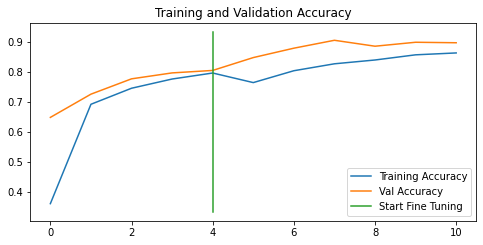

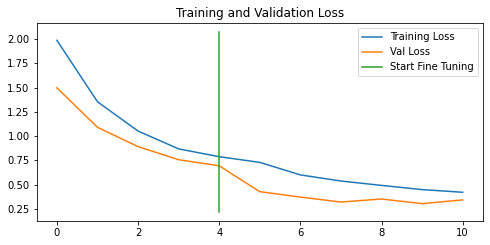

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)


## Viewing our experiment data on TensorBoard
🔑 Note: Anything you upload to TensorBoard.dev is going to be public. So if you have private data, 

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=iSqUaiIudeGoltqAISCgbPSZ8bsAbI&prompt=consent&access_type=o

In [ ]:
# # View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

https://tensorboard.dev/experiment/VKrb8Y5mSlG7VbbowilKuw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   VKrb8Y5mSlG7VbbowilKuw
	Created              2022-02-08 15:07:46 (6 minutes ago)
	Updated              2022-02-08 15:07:49 (6 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              102
	Tensor bytes         0
	Binary object bytes  2543253
https://tensorboard.dev/experiment/uXwYHXc2S5yjB6WoZPUQyw/
	Name                 efficientnetB0 vs. resnet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of data
	Id                   uXwYHXc2S5yjB6WoZPUQyw
	Created              2022-02-05 08:10:12
	Updated              2022-02-05 08:10:14
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary o

In [ ]:
 # To delete an experiment
!tensorboard dev delete --experiment_id VKrb8Y5mSlG7VbbowilKuw
!tensorboard dev delete --experiment_id uXwYHXc2S5yjB6WoZPUQyw
!tensorboard dev delete --experiment_id 9gRNwi2wQimEaQgpYfNwGA

Deleted experiment VKrb8Y5mSlG7VbbowilKuw.
Deleted experiment uXwYHXc2S5yjB6WoZPUQyw.
Deleted experiment 9gRNwi2wQimEaQgpYfNwGA.


In [ ]:
# # View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
